### Import LIbraries

In [113]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas.plotting as pdplt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

### Import Data

In [114]:
data_path = os.path.join(os.path.pardir, 'data')
titanic_train_path = os.path.join(data_path, 'train.csv')
titanic_test_path = os.path.join(data_path, 'test.csv')

In [115]:
titanic_train = pd.read_csv(titanic_train_path, index_col='PassengerId')
titanic_test = pd.read_csv(titanic_test_path, index_col='PassengerId')

### Data Structure

In [116]:
titanic_train.shape, titanic_test.shape

((891, 11), (418, 10))

In [117]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


### Statistical Summary

In [118]:
titanic_train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

### Data Munging 

In [119]:
titanic_test['Survived'] = -999 # Adding Survived with a default value

In [120]:
data = pd.concat((titanic_train, titanic_test), axis=0, sort=True)

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
Age         1046 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
Fare        1308 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    1309 non-null int64
Ticket      1309 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


## Feature Selection

### Embarked

In [122]:
data[data.Embarked.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
62,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,1,female,0,1,113572
830,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,1,female,0,1,113572


In [123]:
data.Embarked.fillna('C', inplace=True)

In [124]:
data[data.Embarked.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,


### Fare

In [125]:
data[data.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1044,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,3,male,0,-999,3701


In [126]:
median_fare = data.loc[(data.Pclass == 3) & (data.Embarked == 'S'),'Fare'].median()

In [127]:
data.Fare.fillna(median_fare, inplace=True)

In [128]:
data[data.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,


In [129]:
data['FareBin'] = pd.qcut(data.Fare, 4, labels=['very_low','low','high','very_high'])

In [130]:
data['FareBin'].value_counts()

very_low     337
high         328
very_high    323
low          321
Name: FareBin, dtype: int64

In [131]:
pd.crosstab(data[data.Survived != -999].Survived, data[data.Survived != -999].FareBin)

FareBin,very_low,low,high,very_high
Survived,,,,
0,179,156,128,86
1,44,68,101,129


### Age

In [132]:
def get_common_title(name):
    title_map = {'mr' : 'Mr', 
               'mrs' : 'Mrs', 
               'miss' : 'Miss', 
               'master' : 'Master',
               'don' : 'Sir',
               'rev' : 'Sir',
               'dr' : 'Officer',
               'mme' : 'Mrs',
               'ms' : 'Mrs',
               'major' : 'Officer',
               'lady' : 'Lady',
               'sir' : 'Sir',
               'mlle' : 'Miss',
               'col' : 'Officer',
               'capt' : 'Officer',
               'the countess' : 'Lady',
               'jonkheer' : 'Sir',
               'dona' : 'Lady'
                 }
    fname_title = name.split(',')[1]
    title = fname_title.split('.')[0]
    title = title.strip().lower()
    return title_map[title]

In [133]:
data['Title'] = data.Name.map(get_common_title)

In [134]:
title_age_median = data.groupby('Title').Age.transform('median')
data.Age.fillna(title_age_median , inplace=True)

In [135]:
data[data.Age.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,FareBin,Title
PassengerId,,,,,,,,,,,,,


### Age

In [136]:
data['AgeState'] = np.where(data['Age'] >= 15, 'Adult','Child')

In [137]:
data['AgeState'].value_counts()

Adult    1192
Child     117
Name: AgeState, dtype: int64

In [138]:
pd.crosstab(data[data.Survived != -999].Survived, data[data.Survived != -999].AgeState)

AgeState,Adult,Child
Survived,,
0,514,35
1,295,47


### Family

In [139]:
data['FamilySize'] = data.Parch + data.SibSp + 1

In [140]:
pd.crosstab(data[data.Survived != -999].Survived, data[data.Survived != -999].FamilySize)

FamilySize,1,2,3,4,5,6,7,8,11
Survived,,,,,,,,,
0,374,72,43,8,12,19,8,6,7
1,163,89,59,21,3,3,4,0,0


In [141]:
#data['IsAlone'] = np.where((data.FamilySize == 1), 1, 0)

In [142]:
#fmap = {1: 'single', 2: 'small', 3: 'small', 4:'small', 5:'medium', 6:'medium', 7: 'large', 8:'large', 11:'large'}
#data['FamilyBin'] = data.FamilySize.map(fmap)

In [143]:
#pd.crosstab(data[data.Survived != -999].Survived, data[data.Survived != -999].FamilyBin)

### Mother 

In [144]:
data['IsMother'] = np.where(((data.Sex == 'female') & (data.Parch > 0) & (data.Age > 18) & (data.Title != 'Miss')), 1, 0)

In [145]:
pd.crosstab(data[data.Survived != -999].Survived, data[data.Survived != -999].IsMother)

IsMother,0,1
Survived,,
0,533,16
1,303,39


In [146]:
data.loc[data.Cabin == 'T', 'Cabin'] = np.NaN

In [147]:
def get_deck(cabin):
    return np.where(pd.notnull(cabin),str(cabin)[0].upper(),'Z')

In [148]:
data['Deck'] = data['Cabin'].map(get_deck)

In [149]:
data[data.Deck.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,FareBin,Title,AgeState,FamilySize,IsMother,Deck
PassengerId,,,,,,,,,,,,,,,,,


In [150]:
pd.crosstab(data[data.Survived != -999].Survived, data[data.Survived != -999].Deck)

Deck,A,B,C,D,E,F,G,Z
Survived,,,,,,,,
0,8,12,24,8,8,5,2,482
1,7,35,35,25,24,8,2,206


### Feature Encoding

In [151]:
data['IsMale'] = np.where(data.Sex == 'male', 1, 0)

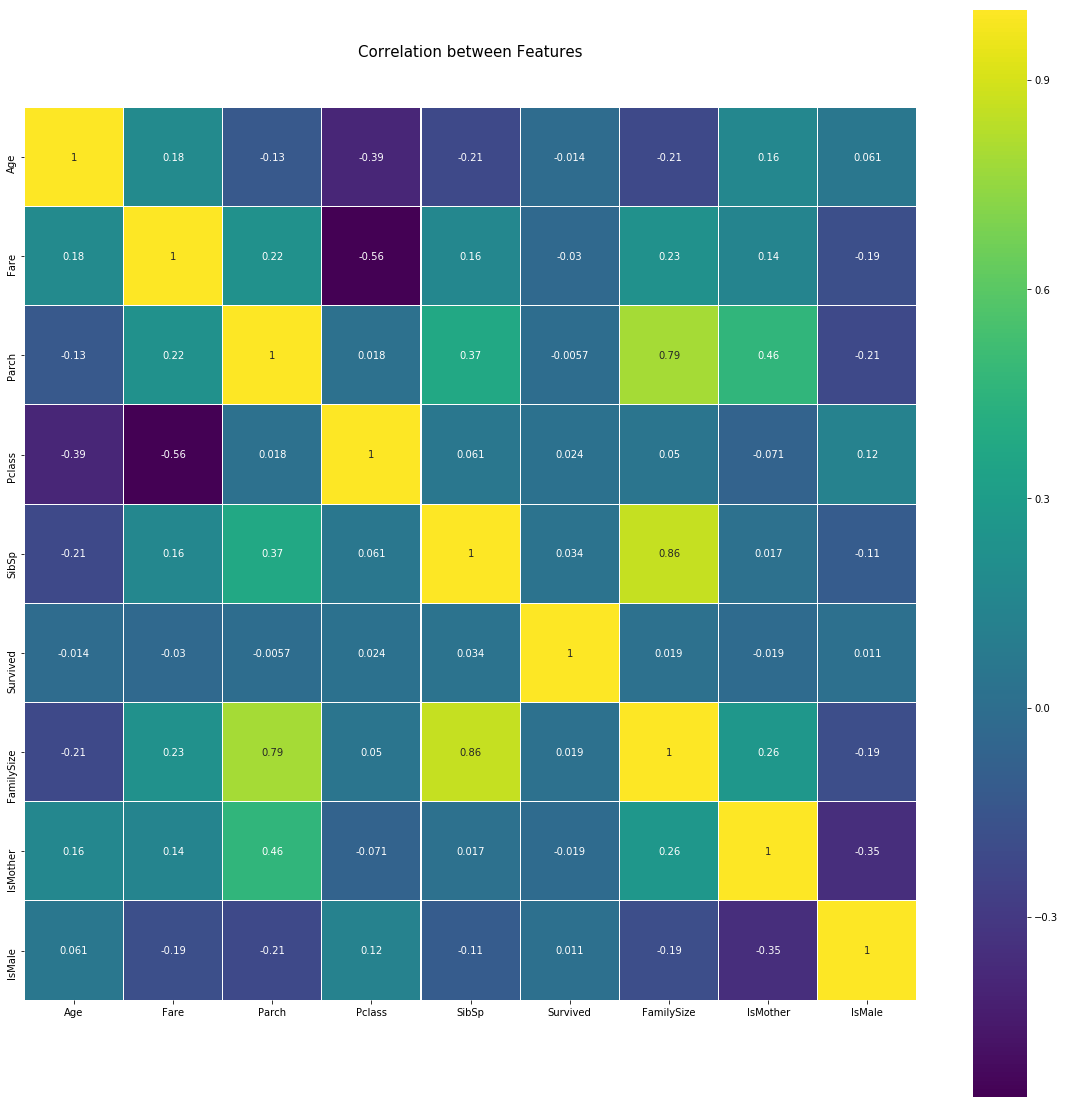

In [152]:
colormap = plt.cm.viridis
plt.figure(figsize=(20,20))
plt.title('Correlation between Features', y=1.05, size = 15)
sns.heatmap(data.corr(),
            linewidths=0.1, 
            vmax=1.0, 
            square=True, 
            cmap=colormap, 
            linecolor='white', 
            annot=True)

In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 18 columns):
Age           1309 non-null float64
Cabin         294 non-null object
Embarked      1309 non-null object
Fare          1309 non-null float64
Name          1309 non-null object
Parch         1309 non-null int64
Pclass        1309 non-null int64
Sex           1309 non-null object
SibSp         1309 non-null int64
Survived      1309 non-null int64
Ticket        1309 non-null object
FareBin       1309 non-null category
Title         1309 non-null object
AgeState      1309 non-null object
FamilySize    1309 non-null int64
IsMother      1309 non-null int32
Deck          1309 non-null object
IsMale        1309 non-null int32
dtypes: category(1), float64(2), int32(2), int64(5), object(8)
memory usage: 175.3+ KB


In [157]:
df = data.copy()

In [158]:
df = pd.get_dummies(df,columns=['Embarked', 'FareBin', 'Title', 'AgeState', 'Deck'])

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 37 columns):
Age                  1309 non-null float64
Cabin                294 non-null object
Fare                 1309 non-null float64
Name                 1309 non-null object
Parch                1309 non-null int64
Pclass               1309 non-null int64
Sex                  1309 non-null object
SibSp                1309 non-null int64
Survived             1309 non-null int64
Ticket               1309 non-null object
FamilySize           1309 non-null int64
IsMother             1309 non-null int32
IsMale               1309 non-null int32
Embarked_C           1309 non-null uint8
Embarked_Q           1309 non-null uint8
Embarked_S           1309 non-null uint8
FareBin_very_low     1309 non-null uint8
FareBin_low          1309 non-null uint8
FareBin_high         1309 non-null uint8
FareBin_very_high    1309 non-null uint8
Title_Lady           1309 non-null uint8
Title_Master         1309

In [160]:
df.drop(['Age','Cabin','Fare','Name','Parch','Sex','SibSp','Ticket'], axis=1, inplace=True)

In [161]:
train_df = df.loc[df.Survived != -999]

In [162]:
columns = [column for column in df.columns if column != 'Survived']
test_df = df.loc[df.Survived == -999, columns]

In [163]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 29 columns):
Pclass               891 non-null int64
Survived             891 non-null int64
FamilySize           891 non-null int64
IsMother             891 non-null int32
IsMale               891 non-null int32
Embarked_C           891 non-null uint8
Embarked_Q           891 non-null uint8
Embarked_S           891 non-null uint8
FareBin_very_low     891 non-null uint8
FareBin_low          891 non-null uint8
FareBin_high         891 non-null uint8
FareBin_very_high    891 non-null uint8
Title_Lady           891 non-null uint8
Title_Master         891 non-null uint8
Title_Miss           891 non-null uint8
Title_Mr             891 non-null uint8
Title_Mrs            891 non-null uint8
Title_Officer        891 non-null uint8
Title_Sir            891 non-null uint8
AgeState_Adult       891 non-null uint8
AgeState_Child       891 non-null uint8
Deck_A               891 non-null uint8
Deck_B         

In [164]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 28 columns):
Pclass               418 non-null int64
FamilySize           418 non-null int64
IsMother             418 non-null int32
IsMale               418 non-null int32
Embarked_C           418 non-null uint8
Embarked_Q           418 non-null uint8
Embarked_S           418 non-null uint8
FareBin_very_low     418 non-null uint8
FareBin_low          418 non-null uint8
FareBin_high         418 non-null uint8
FareBin_very_high    418 non-null uint8
Title_Lady           418 non-null uint8
Title_Master         418 non-null uint8
Title_Miss           418 non-null uint8
Title_Mr             418 non-null uint8
Title_Mrs            418 non-null uint8
Title_Officer        418 non-null uint8
Title_Sir            418 non-null uint8
AgeState_Adult       418 non-null uint8
AgeState_Child       418 non-null uint8
Deck_A               418 non-null uint8
Deck_B               418 non-null uint8
Deck_C      

In [165]:
X = train_df.loc[:, train_df.columns != 'Survived']

In [166]:
Y = train_df['Survived']

In [167]:
X.shape, Y.shape

((891, 28), (891,))

In [168]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=.2, random_state=0)

In [169]:
# Spot-Check Algorithms 
models = [] 
models.append(('LR', LogisticRegression())) 
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('XGB', XGBClassifier()))
# evaluate each model in turn 
results = [] 
names = [] 
for name, model in models: 
    kfold = KFold(n_splits=10, random_state=7) 
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy') 
    results.append(cv_results) 
    names.append(name) 
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) 
    print(msg)

LR: 0.825900 (0.024863)
RF: 0.800528 (0.030263)
GB: 0.816021 (0.034107)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

XGB: 0.825802 (0.029878)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [170]:
params_logreg = [{'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1','l2']}]
grid_logreg = GridSearchCV(estimator = LogisticRegression(),
                           param_grid = params_logreg,
                           scoring = 'accuracy',
                           cv = 10)
grid_logreg = grid_logreg.fit(X_train, Y_train)
best_acc_logreg = grid_logreg.best_score_
best_params_logreg = grid_logreg.best_params_

In [171]:
params_rforest = [{'n_estimators': [50, 100],
                   'max_depth': [5, 7, 10],
                   'min_samples_split': [2, 4]}]
grid_rforest = GridSearchCV(estimator = RandomForestClassifier(criterion = 'gini',random_state = 0, n_jobs=-1),
                            param_grid = params_rforest,
                            scoring = 'accuracy',
                            cv = 10)
grid_rforest = grid_rforest.fit(X_train, Y_train)
best_acc_rforest = grid_rforest.best_score_
best_params_rforest = grid_rforest.best_params_

In [172]:
params_gboost = [{'n_estimators': [50,100,200],
                   'max_depth': [6,8,10],
                   'min_samples_split': [10, 20, 30]}]
grid_gboost = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, random_state=10),
                            param_grid = params_gboost,
                            scoring = 'accuracy',
                            cv = 10)
grid_gboost = grid_gboost.fit(X_train, Y_train)
best_acc_gboost = grid_gboost.best_score_
best_params_gboost = grid_gboost.best_params_

In [173]:
params_xgb = [{'n_estimators': [20,81,10],
                   'max_depth': [5, 6, 12],
                   'min_samples_split': [200, 1000, 200]}]
grid_xgb = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, random_state=10),
                            param_grid = params_xgb,
                            scoring = 'accuracy',
                            cv = 10)
grid_xgb = grid_xgb.fit(X_train, Y_train)
best_acc_xgb = grid_xgb.best_score_
best_params_xgb = grid_xgb.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

In [174]:
grid_score_dict = {'Best Score': [best_acc_logreg,best_acc_rforest, best_acc_gboost, best_acc_xgb],
                   'Optimized Parameters': [best_params_logreg,best_params_rforest, best_params_gboost, best_params_xgb],
                  }
pd.DataFrame(grid_score_dict, index=['Logistic Regression','Random Forest', 'Gradient Boosting', 'XGB Classifier'])

,Best Score,Optimized Parameters
Logistic Regression,0.831461,"{'C': 1, 'penalty': 'l1'}"
Random Forest,0.827247,"{'max_depth': 7, 'min_samples_split': 4, 'n_es..."
Gradient Boosting,0.817416,"{'max_depth': 6, 'min_samples_split': 30, 'n_e..."
XGB Classifier,0.825843,"{'max_depth': 5, 'min_samples_split': 200, 'n_..."


In [158]:
best_params_gboost

{'max_depth': 6, 'min_samples_split': 20, 'n_estimators': 20}

In [175]:
lr = LogisticRegression(C=1.0, penalty = 'l1')
lr.fit(X_train, Y_train) 
predictions = lr.predict(X_val) 
print(accuracy_score(Y_val, predictions)) 
print(confusion_matrix(Y_val, predictions)) 
print(classification_report(Y_val, predictions))

0.8212290502793296
[[94 16]
 [16 53]]
             precision    recall  f1-score   support

          0       0.85      0.85      0.85       110
          1       0.77      0.77      0.77        69

avg / total       0.82      0.82      0.82       179



In [95]:
best_params_rforest

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}

In [177]:
rfc = RandomForestClassifier(max_depth=10, min_samples_split=2,n_estimators=100)
rfc.fit(X_train, Y_train) 
predictions = rfc.predict(X_val) 
print(accuracy_score(Y_val, predictions)) 
print(confusion_matrix(Y_val, predictions)) 
print(classification_report(Y_val, predictions))

0.8212290502793296
[[99 11]
 [21 48]]
             precision    recall  f1-score   support

          0       0.82      0.90      0.86       110
          1       0.81      0.70      0.75        69

avg / total       0.82      0.82      0.82       179



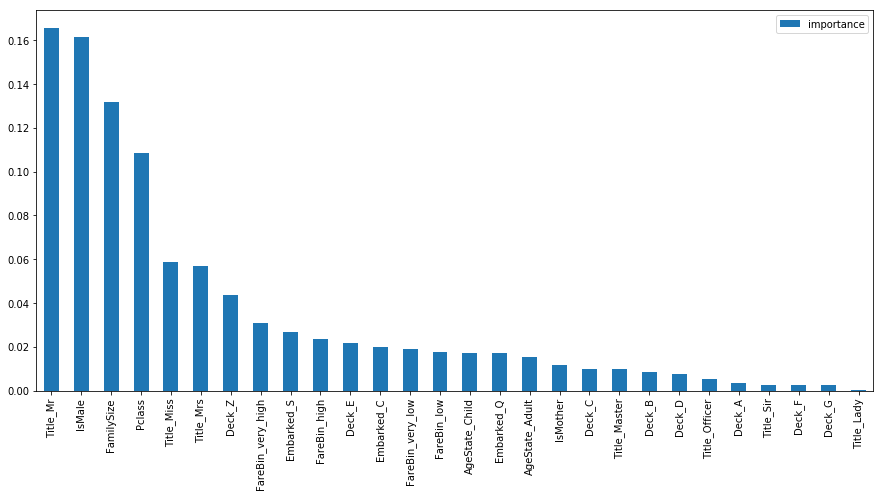

In [178]:
feature_importances = pd.DataFrame(rfc.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.plot(kind='bar', figsize=(15,7))

In [179]:
gbc = GradientBoostingClassifier(max_depth=10, min_samples_split=2,n_estimators=10)
gbc.fit(X_train, Y_train) 
predictions = gbc.predict(X_val) 
print(accuracy_score(Y_val, predictions)) 
print(confusion_matrix(Y_val, predictions)) 
print(classification_report(Y_val, predictions))

0.8212290502793296
[[97 13]
 [19 50]]
             precision    recall  f1-score   support

          0       0.84      0.88      0.86       110
          1       0.79      0.72      0.76        69

avg / total       0.82      0.82      0.82       179



In [180]:
def get_submission_file(model, filename):
    # converting to the matrix
   # test_X = test_df.as_matrix().astype('float')
    # make predictions
    predictions = model.predict(test_df)
    # submission dataframe
    df_submission = pd.DataFrame({'PassengerId': test_df.index, 'Survived' : predictions})
    # submission file
    submission_data_path = os.path.join(os.path.pardir,'data','output')
    submission_file_path = os.path.join(submission_data_path, filename)
    # write to the file
    df_submission.to_csv(submission_file_path, index=False)

In [181]:
get_submission_file(lr, '05_lr.csv')

In [182]:
get_submission_file(rfc, '05_rfc.csv')

In [183]:
get_submission_file(gbc, '05_gbc.csv')